# Introduction

I've been interested in the mechanics of language modeling for some time--without the marketing hype attached with the popularity of large language models. During my studies, I came across Andrej Karpathy's [makemore video series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ). He progressively builds up the concepts and code that lead to generative pre-training transformer (GPT) models starting with character-level language models.

To say the least, this video series is a remarkably detailed set of lectures that really help demystify language modeling all the way up through deep learning concepts. I wanted to try my hand at applying this awesome work on a fun dataset that I've curated myself--DnD fantasy names (the amazing drow)! I like Karpathy's advice on "creating cheatsheets" too, so this post is my personal (large) cheatsheet that hopefully helps beginners like me on their own journey. Let's get started.

# Scraping Fantasy Names

In the makemore series, Karpathy uses a text file of English names. I'm putting a bit of a fantasy spin on it by collecting names from [Fantasy Name Generators - Drow Names](https://www.fantasynamegenerators.com/dnd-drow-names.php). To do this, I created a script to repeatedly play cookie clicker by clicking a button on the page and grabbing the names from the results section that pops up on the site.

The cell below writes a new file with the code into the working directory.

In [15]:
%%writefile scrape.py
from dotenv import load_dotenv
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

load_dotenv()


def click_and_extract(
    driver: WebDriver, button_selector: str, div_selector: str, duration=60
):
    """Repeatedly clicks and extracts text from the fantasy name generator for a specified duration.

    Website used can be found at: https://www.fantasynamegenerators.com/dnd-drow-names.php.
    """
    names = ""  # Maintain a list of names to save
    end_time = time.time() + duration
    while time.time() < end_time:
        try:
            # Waits for a max of 10 sec. until the button element being looked for is found
            button = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, button_selector))
            )
            button.click()
            div = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, div_selector))
            )
            names += div.text.lower() + "\n"  # Added newline char to end of string to separate each section
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    return names


if __name__ == "__main__":
    chrome_options = Options()
    service = Service(os.getenv("CHROMEDRIVER_PATH"))  # Use the chrome driver on system

    driver = webdriver.Chrome(service=service, options=chrome_options)
    url = "https://www.fantasynamegenerators.com/dnd-drow-names.php"
    driver.get(url)

    button_selector = (
        '#nameGen > input[type="button"]'  # Specific button selector for the website
    )
    div_selector = "#result"  # Specific div selector for the generated results

    names = click_and_extract(driver, button_selector, div_selector, duration=120)

    # Write names to a text file
    with open("names.txt", "w") as f:
        f.write(names)

    # Close driver connection
    driver.quit()

Overwriting scrape.py


With some names in hand, we can explore the data some to see what we're working with.

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Read in the names dataset as a list
with open("names.txt", "r") as f:
    names = f.read().splitlines()

print(len(names))

57880


In @fig-name-freq, we can see that there are multiple names that are duplicated throughout the dataset. For this project, we'll only be using unique names and can easily filter out the repeated ones.

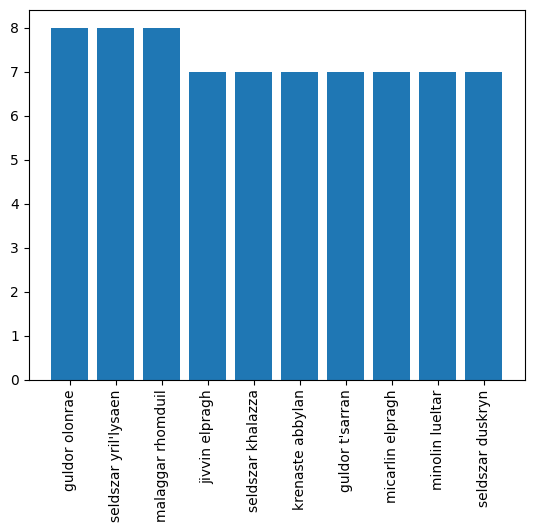

In [17]:
# | label: fig-name-freq
# | fig-cap: A sample bar chart of the most frequent names
name_counts = Counter(names)  # Get the frequency of every name
name_counts = sorted(
    name_counts.items(), key=lambda x: x[1], reverse=True
)  # Sort by descending count

plt.xticks(rotation="vertical")
plt.bar([n[0] for n in name_counts][:10], [n[1] for n in name_counts][:10]);

In [18]:
names = list(set(names))  # Retrieve unique names

with open("names_clean.txt", "w") as f:
    f.write("\n".join(names))

# Bigram Language Model

The first model we can use as a potential baseline is a bigram model. With a bigram model, we will predict a new character based off the previous one. We will also introduce a `.` token to denote the start and end of a string. When generating a new word from scratch, a starting `.` will be used. For an example, where `->` will represent "leads to":

-   In the string `abcd`, `. -> a`, `.a -> b`, `ab -> c`, `bc -> d`, `cd -> .`

The main difference in our dataset from the makemore one is the addition of a blank space (" ") token and an apostrophe (" ' ").

In [19]:
b = {}
for i, n in enumerate(names):
    chs = ["."] + list(n) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

        # Print the first two name examples
        if i < 2:
            print(ch1, ch2)

. y
y u
u i
i m
m d
d a
a e
e r
r  
  v
v r
r o
o n
n r
r a
a e
e .
. b
b a
a t
t r
r a
a g
g  
  j
j h
h a
a l
l a
a r
r r
r a
a n
n .


In [20]:
# Find the most likely bigrams by frequency
sorted(b.items(), key=lambda x: x[1], reverse=True)[0]

(('a', 'r'), 21057)

By collecting the bigram frequencies, we can see which characters are most likely to follow other characters. For example, an `a` is most likely to be followed by an `r` based on the data we have. So we should be able to create a probability distribution out of these frequencies and sample from it to create new names!

Also, these models can't process text directly so we need some way to encode our text numerically to be able to represent the information. When generating new characters at the inference stage, we can also have a decoder to translate the numbers back to text. Makemore indexes the characters in alphabetical order and assigns `.` to be the 0 index. We can do the same here.

In [21]:
chars = sorted(list(set("".join(names))))  # Create the unique vocab set
stoi = {
    s: i for i, s in enumerate(chars, start=1)
}  # Encode the characters by their alphabetical index, starting at index 1
stoi["."] = 0  # Assign the terminating token to index 0
itos = {i: s for s, i in stoi.items()}  # Decode the indices to text
vocab_size = len(stoi)

print(vocab_size)

29


Throughout this project, we will take advantage of PyTorch for its deep learning and general computing capabilities. Instead of representing our bigram frequencies as a list of character pairs and their frequency, we can store this information as a `29x29` tensor based off our `vocab_size`. 

How can we interpret this tensor? Based off our encoding, each row index will represent the first character in a bigram and each column index will represent the second character. Each element in `[row, col]` will be the frequency of that bigram.

In [22]:
itos[17], itos[13], "!"

('o', 'k', '!')

In [23]:
import torch

N = torch.zeros(
    (vocab_size, vocab_size), dtype=torch.int32
)  # Initializating the bigram frequency tensor

In [24]:
# Count the frequency of each bigram and store it in the tensor
for n in names:
    chs = ["."] + list(n) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        N[idx1, idx2] += 1

We can also visualize our tensor in a fun way. You might notice that we have some sparse entries. There is only 1 bigram that occurs where `q` is the first character--`qu`. When it comes to generating names, if a `q` appears then the only character that can appear next is `u`. Now, we might be okay with this, but later when we come to evaluating this model we'll find that this gives us a property that might not like that we'll have to deal with.

(-0.5, 28.5, 28.5, -0.5)

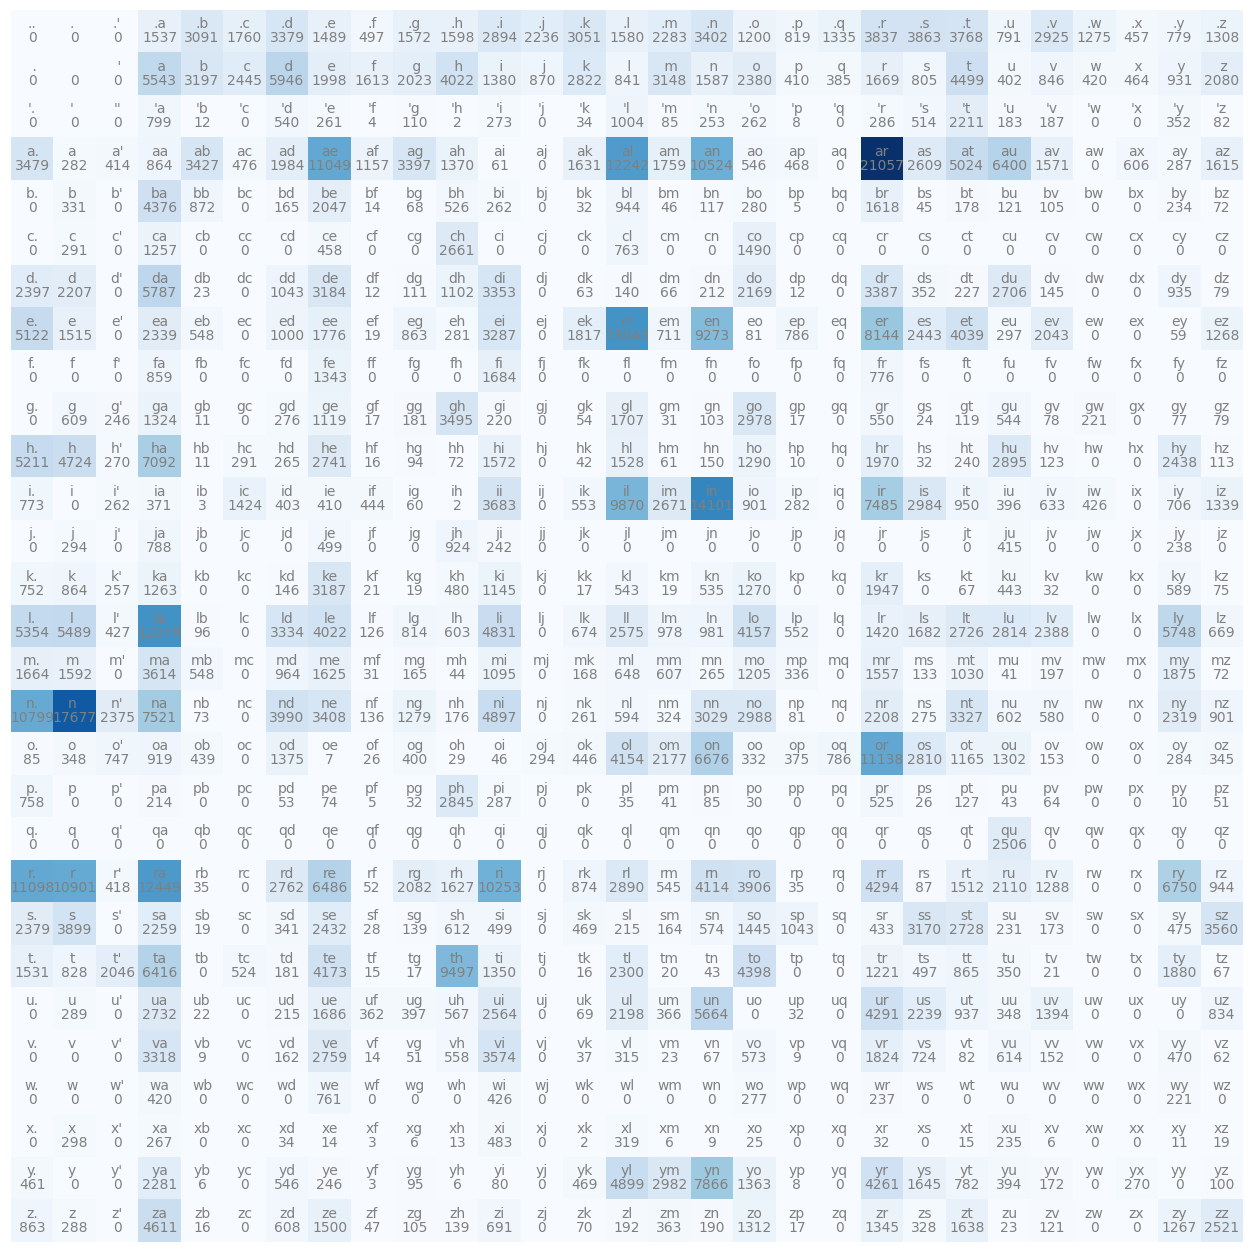

In [25]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

## Generating Characters Through Sampling

With our frequencies in place, we can start generating names! Intuitively, row 0 represents the frequencies of every other character following the `.` character. So if we want to find the probability of each character following `.` then we just have to divide each row entry by the sum of all the row frequencies. We now have a probability distribution for characters following `.`

We'll do the same for every other row and **SHAZAM**... we have a probability matrix we can sample from.

In [26]:
P = N.float()
P /= P.sum(
    dim=1, keepdim=True
)  # By keeping the row dimension, the row sum array will be broadcasted across the rest of P
assert torch.allclose(
    torch.ones(P.shape[0], dtype=torch.float32), P.sum(dim=1)
)  # Check to see that every row sums to 1 in our probability matrix

In [27]:
g = torch.Generator().manual_seed(1234)  # Reproducibility
for i in range(10):
    out = []
    ix = 0  # Start with the `.` character
    while True:
        p = P[ix]
        ix = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()  # Sample from our probability matrix and get back an index which represents the new character

        if ix == 0:  # Terminate if we end up back on the `.` char
            break
        out.append(itos[ix])  # Append the decoded character to our output
    print("".join(out))

irorelelatodele sonzmr
sd
rn kho'gorlavzae
h drinan s
clorhimllan dhelolaarlahimanin aun mtathan
ileryn jhyol'tont
thes cenodaelar zabh
oltenn zalarlyr xl'lan drar alrathurilaly
zamvadrylmdal zekrazarifar
duendalaurrilelyaeanina'auicod


I'd love to see a DnD character with the name `duendalaurrilelyaeanina'auicod`. Unfortunately, I don't know any that exist yet. There are definitely some names that sound like they *could* be in DnD like `ileryn` and `zekrazarifar`, but also we can see some strange artifacts like `sd` and `rn` hanging around.

Compared to typical English names, it can be difficult to verify how good the output is or even if the bigram model is working as expected. One sanity check is to make every character have uniform probability--every character is equally likely to be sampled.

In [28]:
g = torch.Generator().manual_seed(1234)  # Reproducibility
for i in range(10):
    out = []
    ix = 0  # Start with the `.` character
    while True:
        # p = P[ix]
        p = torch.ones(vocab_size) / vocab_size  # Uniform distribution
        ix = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()  # Sample from our probability matrix and get back an index which represents the new character

        if ix == 0:  # Terminate if we end up back on the `.` char
            break
        out.append(itos[ix])  # Append the decoded character to our output
    print("".join(out))

wxoorlbqjaodxlfwsoizmjzsd'rlovhj'govlnvzqpchkdlijvfqswc
oyhimsljayrhnjxlaawlmhifanicgempzuhatngychlmwffvjdm'u'fkdsftyfsdc
suplhfqkrzwpfpxlf'ezpz'lqrlpfnxc'cqqcdbac airmqhugilnkr
zbmvpdrtbmdyf ze raw'ipfo xduccyaqrimwuieqwpeaosca'ndiccd
'tzbyl lyhzbzchnfqtjdcwzyrhy q klmsod yafxwcbwziqu'mtdhhycrjpmjdmhcnowtcdzffadoebpodazgqqjswqudquwanz'ncaktcxk
mqulrvhoez
kupksskhynn
l efaqjvcrpljcxqn
rayi
z


All hail the demonic `wxoorlbqjaodxlfwsoizmjzsd'rlovhj'govlnvzqpchkdlijvfqswc`. Your soul will be split in half just trying to pronounce that. It definitely seems like the bigram model is working to an extent. 

However, we can still have a bit more confidence by having a method to summarize our model numerically.

# Maximizing the Log-Likelihood (Minimizing the Negative Log-Likelihood)

**Likelihood** refers to the probability of observing our data under a specific model and set of model parameters. In the context of model optimization, we are trying to optimize our parameter values that will maximize some likelihood function. For each independent character class, we multiply our probabilities of predicting that character together to get our likelihood.

However, in practice we will use **log-likelihood**, particular for three reasons:

-   Log-likelihood is a **monotonic** transformation. Maximizing the log-likelihood also maximizes the original likelihood.
-   Sums are easier to work with than products. Mathematically, by applying $\log$ to a product we can represent it as a summation instead: $\log(a \cdot b \cdot c) = \log(a) + \log(b) + \log(c)$. Eventually, when it comes to building a neural net this is also an easily differentiable operation.
-   Products are not as numerically stable as they tend to converge quickly to zero or infinity. Imagine you are multiplying many small decimals (which in our case definitely applies), the product will be extremely small.

Essentially, taking the natural log of our probabilities gives us a nice smooth function that also squeezes extreme numbers to be within a smaller range while still maximizing our original objective. 

In machine learning, when optimizing our model with a loss function, semantically lower is better. We can use the **negative log-likelihood** which still retains the same properties, but is now being minimized instead of maximized. Given our model's output probabilities, we calculate $-\log(\hat{y})$ where $\hat{y}$ is the prediction for the true character class and then find the mean across every sample for an aggregate loss.

 @fig-nll-plot shows the negative log function to visualize how higher probabilities lower the loss. We can interpret this as having higher confidence in the correct character leads to a lower loss while having lower confidence leads to a higher loss.

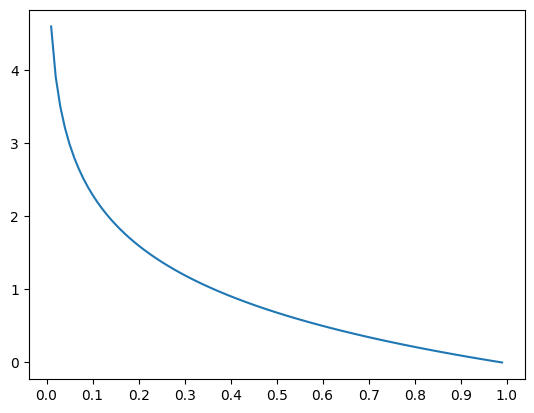

In [72]:
#| label: fig-nll-plot
#| fig-cap: Plot of negative log function
plt.plot(-torch.linspace(0, 1, 100).log())
plt.xticks(
    ticks=torch.arange(0, 110, 10), labels=[f"{i/100:.1f}" for i in range(0, 110, 10)]
);

Calculating the negative log-likelihood across our dataset:

In [73]:
log_likelihood = 0.0
n_ele = 0

for n in names:
    chs = ["."] + list(n) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        log_likelihood += torch.log(P[ix1, ix2])
        n_ele += 1

nll = -log_likelihood
print(f"{nll = }")
print(f"{nll/n_ele = }")

nll = tensor(2235444.5000)
nll/n_ele = tensor(2.5295)


Great! We now have a metric to summarize our classifier to compare with other models. We might be interested in seeing the loss from our uniform, equal probability model. Let's try that out now.

In [74]:
P_unif = torch.ones_like(N, dtype=torch.float32)
# P_unif /= P_unif.sum(dim=1, keepdim=True)
P_unif /= vocab_size
assert torch.allclose(
    torch.ones(P_unif.shape[0], dtype=torch.float32), P_unif.sum(dim=1)
)

In [75]:
log_likelihood = 0.0
n_ele = 0

for n in names:
    chs = ["."] + list(n) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        log_likelihood += torch.log(P_unif[ix1, ix2])
        n_ele += 1

nll = -log_likelihood
print(f"{nll = }")
print(f"{nll/n_ele = }")

nll = tensor(2949547.5000)
nll/n_ele = tensor(3.3376)


In terms of metrics alone, the bigram model does seem to have an edge over the uniform model. Qualitatively, the bigram model outputs also seem to be a bit better for creating the perfect warlock. We have a decent roll of the dice--can we do **EVEN BETTER**?

In the video, a neural net framework is created for the bigram model to better scale with increasing amounts of characters predicting the next character. In an n-gram model ($n$ characters predicting the next)--you would have $(29^n) \times 29$ frequency matrix. 